In [1]:
# Follow instructions from https://github.com/AierLab/indl-dataset to generate data

In [2]:
# Import packages
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset 
from PIL import Image
from torch.utils.data.dataloader import default_collate

#from scripts import Worker

/Users/leery/miniconda3/envs/dalgi/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set wd

path_to_set = "/Users/leery/Documents/EllaNB240" # paste path here
os.chdir(path_to_set)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/leery/Documents/EllaNB240


In [4]:
# # # Generate data
# !python data/data_generate.py

In [5]:
# CONFIG #
# Adapted from Assignment 2 codebase

# TRAINING SETTINGS
NUM_EPOCHS = 12


# LEARNING RATE SETTINGS
BASE_LR = 0.01
DECAY_WEIGHT = 0.0001 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
DATA_DIR = 'InDL' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 64 # originally 10


# GPU SETTINGS
#TORCH_DEVICE = 'mps:0' # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
device = torch.device("mps")
GPU_MODE = 1 # set to 1 if want to run on gpu.


# SETTINGS FOR DISPLAYING ON TENSORBOARD
USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.


In [6]:
# # Concatenate all label files to create a dict
# # Source: ChatGPT; prompt: 'how do I write a python code to go through 5 folders and concatenate all .csv files in each folder (all named labels.csv)'

# # Path to the parent directory containing the 5 folders
# parent_dir = "/Users/ellacho/Documents/NB240/indl-dataset-main/train"

# # Get list of folder names (you could also specify them manually)
# folders = sorted(os.listdir(parent_dir))  # ensure only 5 folders

# # List to store DataFrames
# dfs = []

# for folder in folders:
#     csv_path = os.path.join(parent_dir, folder, "label.csv")
#     if os.path.exists(csv_path):
#         df = pd.read_csv(csv_path)
#         dfs.append(df)

# # Concatenate all the DataFrames
# train_combined_df = pd.concat(dfs, ignore_index=True)

# # Optional: save to a new CSV
# train_combined_df.to_csv("train_label.csv", index=False)

In [7]:
# Create dictionaries for labels 

train_meta = pd.read_csv('/Users/leery/Documents/EllaNB240/train_label.csv')
test_meta = pd.read_csv('/Users/leery/Documents/EllaNB240/test_label.csv')

train_meta = train_meta[['name', 'label']].copy()
test_meta = test_meta[['name', 'label']].copy()

train_meta_dict = train_meta.set_index('name').T.to_dict('list')
test_meta_dict = test_meta.set_index('name').T.to_dict('list')

# Combine
full_dict = {**train_meta_dict, **test_meta_dict}

In [8]:
# Define transformations for training and validation
# Adapted from Assignment 2 codebase

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(72),
        transforms.RandomCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
class InDL(Dataset):
  def __init__(self, split = "train", transform=None, target_transform=None):

    # self.data_dir = "/Users/ellacho/Documents/NB240/indl-dataset-main/data"
    self.data_dir = "/Users/leery/Documents/EllaNB240/indl-dataset-main/datasets"

    self.transform = transform
    self.split = split
    self.target_transform = target_transform

    # Define class dictionary
    self.class_dict = {i: f"class[{i}]" for i in range(0, 1)}

    # Create empty list for storing filepath and image label
    self.items = []

    # Define logic to find training data and fill the dict

    if self.split == 'train':
       for folder in glob.glob(f"{self.data_dir}/train/**/"):
          # Iterate through different .png files in each dataset folder
          for file in os.listdir(folder):
            if file.startswith("."):  # skip .DS_Store and other hidden files
              continue
          
            image_name = file
            image_label = full_dict[image_name]
            image_path = os.path.join(folder, image_name)

            self.items.append((image_path, image_label[0]))

    elif self.split == 'val':
       for folder in glob.glob(f"{self.data_dir}/test/**/"):
          # Iterate through different .png files in each dataset folder
          for file in os.listdir(folder):
            if file.startswith("."):  # skip .DS_Store and other hidden files
              continue
          
            image_name = file
            image_label = full_dict[image_name]
            image_path = os.path.join(folder, image_name)

            self.items.append((image_path, image_label[0]))

    print(f"Loaded {len(self.items)} images for {self.split} dataset.")

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):

    # Added additional code from generative AI (prompt: fix bug "TypeError: Variable data has to be a tensor, but got list.")
    img_path, label = self.items[idx]
    image = Image.open(img_path).convert("RGB")

    if self.transform:
        image = self.transform(image)  # Ensure transform outputs a tensor
    else:
        image = transforms.ToTensor()(image)

    label = torch.tensor(label, dtype=torch.long) # Ensure labels are integers, not lists or floats

    return image, label

In [10]:
# Define training and validation datasets

dsets = {}

for split in ['train', 'val']:
    dsets[split] = InDL(split, data_transforms[split])

Loaded 8000 images for train dataset.
Loaded 2000 images for val dataset.


In [11]:
# Get dataset sizes
dset_sizes = {'train': len(dsets['train']), 'val': len(dsets['val'])}

# Define DataLoaders
dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=default_collate),
    'val': DataLoader(dsets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=default_collate)
}

In [12]:
# Import pertinent packages
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
# Define GPU use
use_gpu = GPU_MODE

In [14]:
import time
import torch
import copy

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs):
    since = time.time()

    best_model = model.to(device)
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter = 0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for inputs, labels in dset_loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter % 10 == 0:
                    print("Reached batch iteration", counter)

                counter += 1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update running loss and correct predictions
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy for this epoch
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            # Deep copy the model if it improves accuracy
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar_value('epoch_loss', epoch_loss, step=epoch)
                    foo.add_scalar_value('epoch_acc', epoch_acc, step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)

        # End of epoch — free MPS memory if needed
        if device.type == 'mps':
            torch.mps.empty_cache()

    # Training time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return best_model, accuracies, losses


In [15]:
# # Define function for modifying learning rate

def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [16]:
# Define model architecture
# From same source as earlier: https://www.kaggle.com/code/datascienceimcomming/cifar10-with-cnn-90-accuracy

model_ft = models.resnet18(pretrained=True)
# model_ft = Model(3, 10)

# Modify the first convolutional layer
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_ft.maxpool = nn.Identity()  # Remove the max pooling layer to preserve resolution
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.to(device)
    model_ft.to(device)

#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.01) # originally lr=0.0001
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

/Users/leery/miniconda3/envs/dalgi/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/leery/miniconda3/envs/dalgi/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Run the functions and save the best model in the function model_ft.
model_ft_4, accuracies_4, losses_4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

----------
Epoch 0/11
----------
LR is set to 0.01
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
train Loss: 0.0112 Acc: 0.6704
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
val Loss: 0.2291 Acc: 0.7095
new best accuracy = 0.7095
----------
Epoch 1/11
----------
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
train Loss: 0.00

In [18]:
# Save model
# batch 10 epoch 7
# torch.save(model_ft.state_dict(), 'InDL_train_val.pt')


# batch 15 epoch 10
# torch.save(model_ft2.state_dict(), 'InDL_train_val_2.pt')

# batch 128 epoch 7
# torch.save(model_ft_3.state_dict(), 'InDL_train_val_3.pt')

# batch 128 epoch 7
torch.save(model_ft_4.state_dict(), 'InDL_train_val_4.pt')

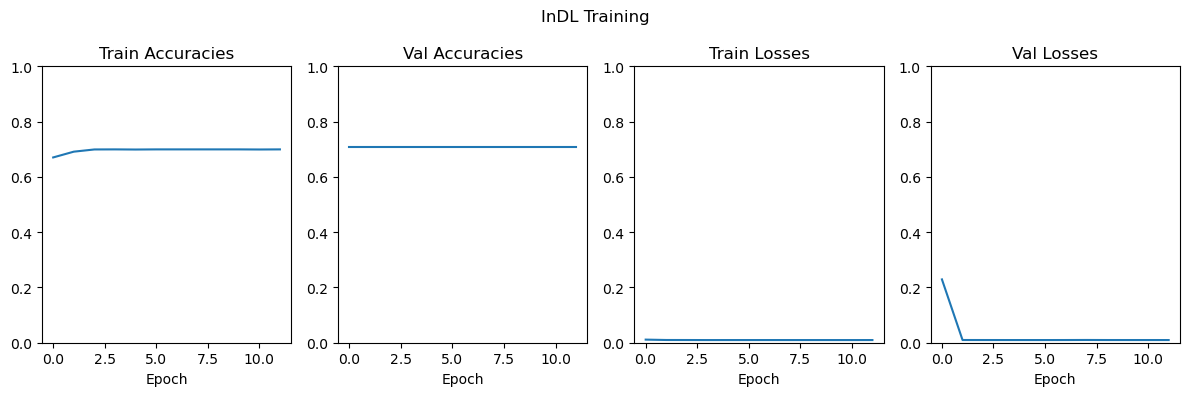

In [20]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize = (12,4))
fig.suptitle("InDL Training", fontsize=12) 

ax[0].plot(accuracies_4['train'])
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(0, 1)

ax[1].plot(accuracies_4['val'])
ax[1].set_title('Val Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0, 1)

ax[2].plot(losses_4['train'])
ax[2].set_title('Train Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim(0, 1)

ax[3].plot(losses_4['val'])
ax[3].set_title('Val Losses')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("InDL_4.png", dpi=300)

plt.show()